_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees Assignment

## Part 1: House Price Regression

Apply decision trees to the Ames housing dataset you've worked with this week!

- Try multiple features
- Try features you've engineered
- Try different `max_depth` paramaters
- What's the best Test Root Mean Squared Error you can get? *Share with your cohort on Slack!*
- What's a cool visualization you can make? *Share with your cohort on Slack!*

In [22]:
import matplotlib.pyplot as plt
import graphviz
from IPython.display import display
from ipywidgets import interact
from IPython.display import SVG
from graphviz import Source
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz



url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'
df = pd.read_csv(url)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].mean())
df = df.dropna(subset=['GarageYrBlt','MasVnrArea'])
cat_vals = {'Gd':4, 'TA':2, 'Ex':5, 'Fa':3, np.NaN:0,'Po':1}
df['BsmtQual'] = df['BsmtQual'].replace(cat_vals)
df['ExterQual'] = df['ExterQual'].replace(cat_vals)
df['PoolQC'] = df['PoolQC'].replace(cat_vals)
df['HeatingQC'] = df['HeatingQC'].replace(cat_vals)
df['KitchenQual'] = df['KitchenQual'].replace(cat_vals)
df['FireplaceQu'] = df['FireplaceQu'].replace(cat_vals)
df['GarageQual'] = df['GarageQual'].replace(cat_vals)
df['ExterCond'] = df['ExterCond'].replace(cat_vals)
df['BsmtCond'] = df['BsmtCond'].replace(cat_vals)
df['GarageCond'] = df['GarageCond'].replace(cat_vals)
df['GarageFinish'] = df['GarageFinish'].replace({'Fin':2,'RFn':1,np.NaN:0,'Unf':-1})
df['PavedDrive'] = df['PavedDrive'].replace({'Y':1,'P':0,'N':-1})
df['LandSlope'] = df['LandSlope'].replace({'Gtl':3,'Mod':2,'Sev':1})
df['CentralAir'] = df['CentralAir'].replace({'Y':1,'N':0})
df['Electrical'] = df['Electrical'].replace({'SBrkr':3,'FuseA':2,'FuseF':1,'FuseP':0,'Mix':2.5,np.NaN:2.5})
df['Foundation'] = df['Foundation'].replace({'Slab':5,'PConc':4,'CBlock':3,'Stone':2,'BrkTil':1,'Wood':0})
df['Street'] = df['Street'].replace({'Grvl':0,'Pave':1})
df['LandContour'] = df['LandContour'].replace({'Lvl':3,'Bnk':2,'HLS':1,'Low':0})
df['LotShape'] = df['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0})
df['ln_SalePrice'] = np.log(df['SalePrice'])
df = df[df.describe().columns]

In [0]:
def viztree(decision_tree, feature_names):
    """Visualize a decision tree"""
    dot_data = export_graphviz(decision_tree, out_file=None, feature_names=feature_names, 
                               filled=True, rounded=True)   
    return graphviz.Source(dot_data)


def viz3D(fitted_model, df, feature1, feature2, target='', num=100):
    """
    Visualize model predictions in 3D, for regression or binary classification
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    df : pandas dataframe, which was used to fit model
    feature1 : string, name of feature 1
    feature2 : string, name of feature 2
    target : string, name of target
    num : int, number of grid points for each feature
    
    References
    ----------
    https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
    https://scikit-learn.org/stable/auto_examples/tree/plot_iris.html  
    """
    x1 = np.linspace(df[feature1].min(), df[feature1].max(), num)
    x2 = np.linspace(df[feature2].min(), df[feature2].max(), num)
    X1, X2 = np.meshgrid(x1, x2)
    X = np.c_[X1.flatten(), X2.flatten()]
    if hasattr(fitted_model, 'predict_proba'):
        predicted = fitted_model.predict_proba(X)[:,1]
    else:
        predicted = fitted_model.predict(X)
    Z = predicted.reshape(num, num)
    
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X1, X2, Z, cmap='viridis')
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_zlabel(target)
    return fig

In [0]:
X = df[['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
     'GrLivArea', 'TotRmsAbvGrd', 'YrSold', 'FullBath']]
y = df['SalePrice']

In [21]:
estimator = DecisionTreeRegressor(max_depth=10)

estimator.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [16]:
print('R^2', estimator.score(X,y))



R^2 0.9746456657066123


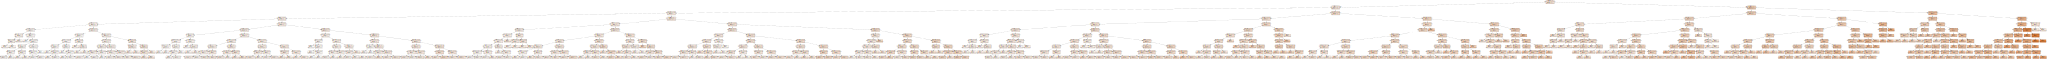

In [26]:
graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=X.columns, class_names=['0', '1', '2'] 
   , filled = True))

display(SVG(graph.pipe(format='svg')))

## Part 2 / Stretch: "Play Tennis" Classification

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

#### "Table 1 shows a small training set"

In [1]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy PlayTennis'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]
tennis = pd.DataFrame(data=data, columns=columns).set_index('No.')
tennis['PlayTennis'] = (tennis['PlayTennis'] == 'P').astype(int)

tennis

,Outlook,Temperature,Humidity,Windy,PlayTennis
No.,,,,,
1,sunny,hot,high,false,0
2,sunny,hot,high,true,0
3,overcast,hot,high,false,1
4,rain,mild,high,false,1
5,rain,cool,normal,false,1
6,rain,cool,normal,true,0
7,overcast,cool,normal,true,1
8,sunny,mild,high,false,0
9,sunny,cool,normal,false,1


#### "A decision tree that correctly classifies each object in the training set is given in Figure 2."

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

In this dataset, the tennis player decided to play on 64% of the days, and decided not to on 36% of the days.

In [0]:
tennis['PlayTennis'].value_counts(normalize=True) * 100

1    64.285714
0    35.714286
Name: PlayTennis, dtype: float64

The tennis player played on 100% of the overcast days, 40% of the sunny days, and 60% of the  rainy days

In [0]:
tennis.groupby('Outlook')['PlayTennis'].mean() * 100

Outlook
overcast    100.0
rain         60.0
sunny        40.0
Name: PlayTennis, dtype: float64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [0]:
sunny = tennis[tennis['Outlook']=='sunny']
sunny.groupby('Humidity')['PlayTennis'].mean() * 100

Humidity
high        0
normal    100
Name: PlayTennis, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [0]:
rainy = tennis[tennis['Outlook']=='rain']
rainy.groupby('Windy')['PlayTennis'].mean() * 100

Windy
false    100
true       0
Name: PlayTennis, dtype: int64

#### Before modeling, we will ["encode" categorical variables, using pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html?highlight=get_dummies#computing-indicator-dummy-variables)

In [0]:
y = tennis['PlayTennis']
X = pd.get_dummies(tennis.drop(columns='PlayTennis'))
X

(14, 10) (14,)


,Outlook_overcast,Outlook_rain,Outlook_sunny,Temperature_cool,Temperature_hot,Temperature_mild,Humidity_high,Humidity_normal,Windy_false,Windy_true
No.,,,,,,,,,,
1,0,0,1,0,1,0,1,0,1,0
2,0,0,1,0,1,0,1,0,0,1
3,1,0,0,0,1,0,1,0,1,0
4,0,1,0,0,0,1,1,0,1,0
5,0,1,0,1,0,0,0,1,1,0
6,0,1,0,1,0,0,0,1,0,1
7,1,0,0,1,0,0,0,1,0,1
8,0,0,1,0,0,1,1,0,1,0
9,0,0,1,1,0,0,0,1,1,0


## Train a Decision Tree Classifier
Get a score of 100% (accuracy)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Compare to Logistic Regression
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Visualize the tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html